# SSL Sherburn outputs
This Notebook was used to create outputs for the Sainsbury's Sherburn report

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import psycopg2
import pipeline_plan_functions.utils.pipe_db_handler as dbh
from python_utils.utils.logger import logger
import alloc_functions.controller as acf
import alloc_functions.feasibility_functions as ff
import pipeline_plan_functions.utils.data_handler as dh
import matplotlib.pyplot as plt
import matplotlib
from pulp import *
import pickle

mapbox_token = ('pk.eyJ1Ijoic29mZmZ0IiwiYSI6ImNrbmZ0Z3RidzJ5NngycXA5cDNpY2c1ajIifQ.Gi2oP1Z3G5wP6pn7OF5l1A')

In [10]:
folder = 'template'

sql_query = f"SELECT * FROM t_vehicles WHERE client_id=2"
cnx = dbh.create_alch_engine()
vehicle_df = pd.read_sql_query(sql_query, con=cnx, index_col='vehicle_id')
vehicle_spec_dict = vehicle_df['spec_id'].to_dict()
good_specs = {100: 'trailers',
              101: '4x2 rigid',
              102: '6x2 rigid',
              103: '4x2 tractor',
              104: '6x2 tractor'}
cnx.dispose()
specs = (101, 102, 103, 104, 111, 112, 113, 114)
vehicle_specifications = ff.find_vehicle_spec(specs)
vehicle_specifications['kwh_mile'] = 0
vehicle_specifications['diesel_l_mile'] = 0
elec_vehicles = vehicle_specifications['fuel_type'] == 'electric'
diesel_vehicles = vehicle_specifications['fuel_type'] == 'diesel'
vehicle_specifications.loc[elec_vehicles, 'kwh_mile'] = vehicle_specifications.loc[elec_vehicles, 'energy_use']
vehicle_specifications.loc[diesel_vehicles, 'diesel_l_mile'] = vehicle_specifications.loc[diesel_vehicles, 'energy_use']
diesel_ev_dict = {
    101: 111,
    102: 112,
    103: 113,
    104: 114
}
site_id = 6
# These are the diesel allocations for each type of vehicle
allocations_diesel = (424, 425, 426, 427)
# These are the EV allocations for each type of vehicle
allocations_ev = (606, 826, 608, 609)
# These are the charging scenarios for the previous allocations
scenarios = {814: '4x2 rigid',
             1256: '6x2 rigid',
             789: '4x2 tractor',
             790: '6x2 tractor'}
site_dict = ff.get_site_name_dict(2)
hgv_drive = vehicle_specifications['energy_use'].to_dict()

In [3]:
def read_telematics_arrivals(run, site):
    COLS = ['departure_time', 'departure_location', 'arrival_time',
        'arrival_location', 'distance_miles', 'driving_time',
        'vehicle_id', 'journey_node_id', 'route_id', 'run', 'client_id',
        'departure_site_id', 'arrival_site_id', 'site_id']
    try:
        cnx = dbh.create_alch_engine()
        cols_telematics = ", ".join(COLS)
        sql_query = f"""SELECT {cols_telematics} FROM t_telematics
            WHERE run = {run} AND arrival_site_id = {site}"""
        telematics = pd.read_sql_query(sql_query, cnx)
        telematics['distance_miles'] = telematics['distance_miles'].clip(lower=0)
    except (Exception, psycopg2.Error) as error:
        logger.error("Error while fetching telematics")
        raise error

    finally:
        cnx.dispose()
    return telematics

FPS_COLOURS = ['#004A9C', '#45D281', '#FEC001', '#A365E0', '#5B9BD5',
               '#FF0000', '#0563C1', '#954F72']
def histo_variable(df, colname, site_name, upperclip=None,
                   lowerclip=None, bins=10, folder="-",
                   suff='', vline_dict=None, title_text=None,
                   plot_mean=True, cumdist=False, xlabel=None, ylabel=None):
    fig, ax = plt.subplots(
        1, figsize=(6, 3), gridspec_kw={'hspace': 0.5})
    if title_text is None:
        title_text = site_name
    ax.set_title(
        f'{title_text}',
        color=FPS_COLOURS[0], fontweight='bold')
    r = ax.hist(
        df[colname].clip(upper=upperclip, lower=lowerclip),
        color=[FPS_COLOURS[0]],
        bins=bins, cumulative=cumdist, density=cumdist)
    if ylabel == None:
        ylabel = '# of routes'
    if xlabel == None:
        xlabel = f'{colname}'
    ax.set_ylabel(ylabel, color=FPS_COLOURS[0])
    ax.set_xlabel(xlabel, color=FPS_COLOURS[0])
    if vline_dict:
        for i, key in enumerate(vline_dict.keys()):
            ax.axvline(x=vline_dict[key], label=key,
                       color=FPS_COLOURS[(i+1) % len(FPS_COLOURS)])
        ax.legend(frameon=False, bbox_to_anchor=(1, 0), loc='lower left')
    if plot_mean:
        ax.axvline(x=df[colname].mean(),
                   color='black', ls='--',
                   label=f"Mean: {np.round(df[colname].mean(), 1)}")
        ax.legend(frameon=False, bbox_to_anchor=(1, 0), loc='lower left')
    fig.savefig(
        f"sample/{folder}/{site_name}_histo_{colname}{suff}.png",
        bbox_inches="tight", dpi=300)
    return


In [4]:
# Get full diesel routes
diesel_list = []
connection, cur = dbh.database_connection('test')
for idx in allocations_diesel:
    alloc = ff.find_allocation(idx)
    diesel_list.append(ff.get_routes(alloc, connection, cur))
routes_diesel = pd.concat(diesel_list)
routes_diesel.sort_values(by=['allocated_vehicle_id', 'departure_time'], inplace=True)
# Calculates how long each vehicle stays on site after each route (in hours)
routes_diesel['next_wait_onsite'] = (routes_diesel['departure_time'].shift(-1)
                                     - routes_diesel['arrival_time']).dt.total_seconds()/3600
routes_diesel['week'] = routes_diesel['departure_time'].dt.isocalendar()['week']
mask_change_veh = routes_diesel['allocated_vehicle_id'] != routes_diesel['allocated_vehicle_id'].shift(-1)
routes_diesel.loc[mask_change_veh, 'next_wait_onsite'] = 0
# Assign the corresponding vehicle ev specification based on the diesel specification
routes_diesel['ev_spec'] = routes_diesel['allocated_spec_id'].map(diesel_ev_dict)
# Calculate the energy required per route if it was done with an EV
routes_diesel['energy_required_kwh'] = routes_diesel['distance_miles'] * routes_diesel['ev_spec'].map(hgv_drive)

### Profiles and simultaneous analysis
This creates a matrix formed by 5 minute intervals, and calculates how many vehicles are on site for each allocation (each type of vehicle). First it defines the time periods in 5 minute intervals covering the ~3 month period. Then for each route it calculates which of the time periods are 1 (vehicle on site) and which ones are 0 (vehicle off site).

During each route the vehicle departs the site (departure_time), then arrives back at the site (arrival_time) and then stays in the depot for some time (next_wait_onsite) and finally leaves again (end_depot_time). The period between arrival_time and next_wait_onsite is what we will consider 1. However this time needs to be rounded to the nearest 5 minute interval.

In [11]:
SHORE_MINUTES = 5  # interval time in minutes
cols = ['allocated_spec_id', 'end_shorepower_tp',
        'arrival_tp', 'date', 'allocated_vehicle_id']
# Create a baseline HH vector covering the whole period
start_dt = dt.datetime(2022, 2, 13)
end_dt = dt.datetime(2022, 5, 1)
N = int((end_dt - start_dt)/dt.timedelta(minutes=SHORE_MINUTES))
# These are the time intervals
times = start_dt + np.arange(N) * dt.timedelta(minutes=SHORE_MINUTES)

routes_diesel['end_depot_time'] = (routes_diesel['arrival_time']
                                   + pd.to_timedelta(routes_diesel['next_wait_onsite'], unit='h'))
# This converts the arrival time into the index of the arrival time period.
routes_diesel['arrival_tp'] = np.round((routes_diesel['arrival_time']-start_dt)
                                       /dt.timedelta(minutes=SHORE_MINUTES)).astype(int)
# This gets the index of the time period when the vehicle leaves the site again
routes_diesel['end_shorepower_tp'] = np.round((routes_diesel['end_depot_time']-start_dt)
                                                 /dt.timedelta(minutes=SHORE_MINUTES)).astype(int)
onsite_matrix = np.zeros((len(allocations_diesel), N))
# iterate over allocations
for i, idx in enumerate(allocations_diesel[:]):
    # extract the routes for the allocation
    mask_routes_alloc = (routes_diesel['allocation_id'] == idx)
    routes_alloc = routes_diesel[mask_routes_alloc][cols]
    if len(routes_alloc) > 0:
        # for each route in the allocation calculate a shorepower availability vector
        for j, route in enumerate(routes_alloc.index[:]):
            tp_arrival = routes_alloc.loc[route, 'arrival_tp']
            tp_end = routes_alloc.loc[route, 'end_shorepower_tp']
            # add to the main allocation vector
            onsite_matrix[i, tp_arrival:tp_end] += 1
pickle.dump(onsite_matrix, open(f'sample/{folder}/onsite_availability_matrix.pkl', 'wb'))


### Outputs

#### Count number of telematics entries

In [41]:
# Get telematics
telematics = read_telematics_arrivals(44, site_id)
telematics['spec_id'] = telematics['vehicle_id'].map(vehicle_spec_dict)

count_groups = routes_diesel.groupby('allocated_spec_id').agg({
    'allocation_id': 'count',
    'allocated_vehicle_id': 'nunique',
    'duty_id': 'nunique'
})
tel_count = telematics.groupby('spec_id')['journey_node_id'].count()
count_groups = count_groups.merge(tel_count, left_index=True, right_index=True)
count_groups.columns = ['n_routes', 'n_vehicles', 'n_duties', 'telematics_arrivals']
count_groups['vehicle'] = count_groups.index.map(good_specs)
count_groups

,n_routes,n_vehicles,n_duties,telematics_arrivals,vehicle
101,4629,55,3966,9578,4x2 rigid
102,545,6,449,1035,6x2 rigid
103,2429,16,1057,5056,4x2 tractor
104,9005,53,3794,17613,6x2 tractor


#### Histograms for routes and vehicle duties

In [14]:
# Groups the routes into daily vehicle duties (super-routes)

duties = routes_diesel.groupby('duty_id').agg({
    'allocated_vehicle_id': 'min',
    'departure_time': 'min',
    'arrival_time': 'max',
    'next_wait_onsite': ['sum', 'last'],
    'energy_required_kwh': 'sum',
    'distance_miles': 'sum'
})
duties.columns = ['vehicle_id', 'departure_time', 'arrival_time', 'total_dwell', 'final_dwell', 'energy_required_kwh', 'distance_miles']
duties['duration_hours'] = (duties['arrival_time'] - duties['departure_time']).dt.total_seconds()/3600
duties

,vehicle_id,departure_time,arrival_time,total_dwell,final_dwell,energy_required_kwh,distance_miles,duration_hours
duty_id,,,,,,,,
1,2333,2022-02-13 06:15:35,2022-02-13 08:53:12,15.515556,15.515556,0.489705,0.211311,2.626944
2,2333,2022-02-14 00:24:08,2022-02-14 05:13:12,15.189444,15.189444,0.820976,0.354257,4.817778
3,2333,2022-02-14 20:24:34,2022-02-15 06:21:06,14.700556,13.983333,412.101015,177.824736,9.942222
4,2333,2022-02-15 20:20:06,2022-02-16 05:22:03,92.386389,91.809167,187.917026,81.087632,9.032500
5,2333,2022-02-20 01:10:36,2022-02-20 03:37:21,21.085556,21.085556,54.083577,23.337477,2.445833
...,...,...,...,...,...,...,...,...
9309,9297,2022-04-12 08:33:55,2022-04-12 10:17:21,49.042778,49.042778,23.526436,13.791175,1.723889
9310,9297,2022-04-14 11:19:55,2022-04-14 14:36:15,41.512500,41.512500,102.948037,60.348042,3.272222
9311,9297,2022-04-16 08:07:00,2022-04-16 15:55:34,308.378611,304.493056,47.137690,27.632070,7.809444


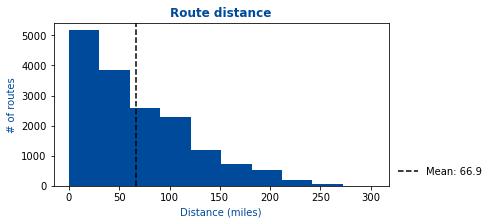

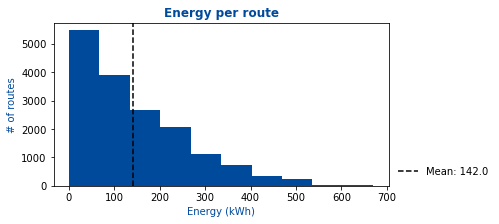

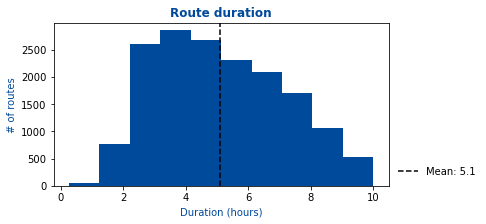

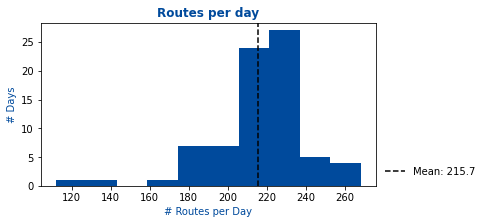

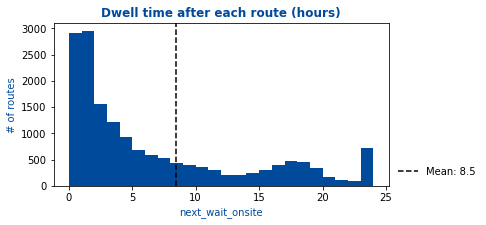

In [15]:
### Outputs based on individual routes

# Route distance
histo_variable(routes_diesel, 'distance_miles', site_dict[site_id], upperclip=None,
                   lowerclip=None, bins=10, folder=folder,
                   suff='_routes', title_text="Route distance",
                   xlabel='Distance (miles)')
# Route energy
histo_variable(routes_diesel, 'energy_required_kwh', site_dict[site_id], upperclip=None,
                   lowerclip=None, bins=10, folder=folder,
                   suff='_routes', title_text='Energy per route',
                   xlabel='Energy (kWh)')
# Route times
histo_variable(routes_diesel, 'duration_hours', site_dict[site_id], upperclip=None,
                   lowerclip=None, bins=10, folder=folder,
                   suff='_routes', title_text='Route duration',
                   xlabel="Duration (hours)")
# Routes per day
histo_variable(routes_diesel.groupby('date')[['shift']].count(),
                  'shift', site_dict[site_id], upperclip=None,
                   lowerclip=None, bins=10, folder=folder,
                   xlabel="# Routes per Day", ylabel='# Days',
                   suff='_routes', title_text='Routes per day')
# Dwell time
histo_variable(routes_diesel,
                  'next_wait_onsite', site_dict[site_id], upperclip=24,
                   lowerclip=None, bins=24, folder=folder,
                   suff='_routes', vline_dict=None, title_text='Dwell time after each route (hours)')

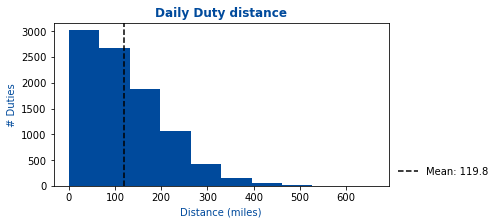

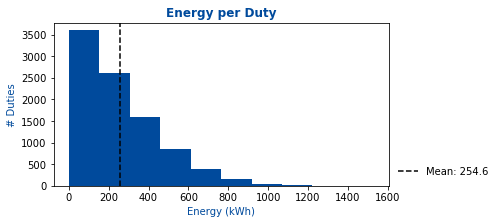

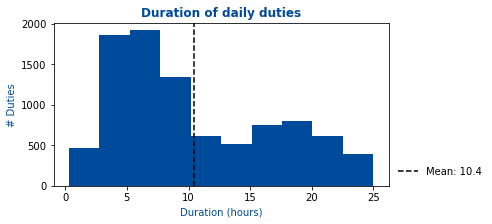

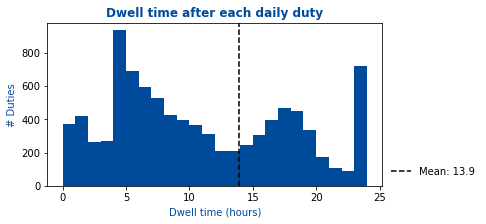

In [16]:
# Histograms based on daily vehicle duties (super-routes)
#  distance
histo_variable(duties, 'distance_miles', site_dict[site_id], upperclip=None,
                   lowerclip=None, bins=10, folder=folder,
                   suff='_duties', vline_dict=None, title_text='Daily Duty distance',
                   xlabel='Distance (miles)', ylabel='# Duties',
                   plot_mean=True, cumdist=False)
#  energy
histo_variable(duties, 'energy_required_kwh', site_dict[site_id], upperclip=None,
                   lowerclip=None, bins=10, folder=folder,
                   suff='_duties', vline_dict=None, title_text='Energy per Duty',
                   xlabel='Energy (kWh)', ylabel='# Duties',
                   plot_mean=True, cumdist=False)
#  times
histo_variable(duties, 'duration_hours', site_dict[site_id], upperclip=None,
                   lowerclip=None, bins=10, folder=folder,
                   suff='_duties', vline_dict=None, title_text="Duration of daily duties",
                   xlabel='Duration (hours)', ylabel='# Duties',
                   plot_mean=True, cumdist=False)
# Dwell time
histo_variable(duties,
                  'final_dwell', site_dict[site_id], upperclip=24,
                   lowerclip=None, bins=24, folder=folder,
                   suff='_duties', vline_dict=None, title_text='Dwell time after each daily duty',
                   xlabel='Dwell time (hours)', ylabel='# Duties')

#### Histograms based on vehicles on-site and charge demand

In [ ]:
# Get the charging scenarios for each of the allocations
try:
    cnx = dbh.create_alch_engine()
    sql_query = f"""SELECT * FROM t_charge_demand
        WHERE scenario_id IN {tuple(scenarios.keys())}"""
    demand = pd.read_sql_query(sql_query, cnx)
    demand['charging'] = demand['power_demand_kw'] > 0.1
except (Exception, psycopg2.Error) as error:
    logger.error("Error getting charge profiles")
    raise(error)
finally:
    cnx.dispose()
# Calculates the total site demand for each of the scenarios and the maximum value in kVA

max_demand = demand.groupby(['scenario_id', 'datetime']).sum().groupby('scenario_id').max()
max_demand_asc = (max_demand[['power_demand_kw']]/0.98).astype(int)
max_demand_asc['vehicle_type'] = max_demand_asc.index.map(scenarios)
max_demand_asc.columns = ('max_demand_kva', 'vehicle_type')
max_demand_asc

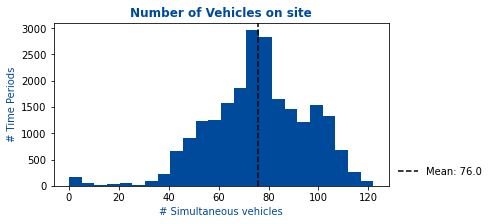

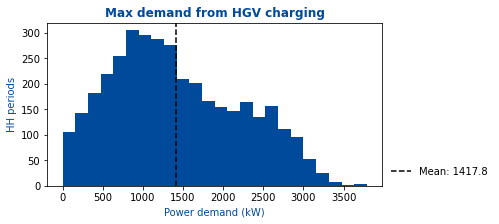

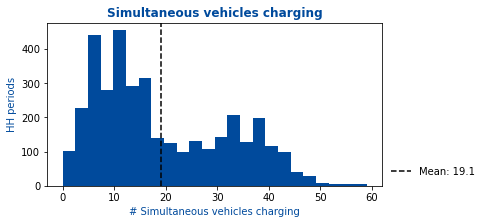

In [17]:
# Charging/on site histograms
df = pd.DataFrame(onsite_matrix.sum(axis=0), columns=['onsite'])
histo_variable(df,
                  'onsite', site_dict[site_id], upperclip=None,
                   lowerclip=None, bins=24, folder="hgv4",
                   suff='', vline_dict=None, title_text='Number of Vehicles on site',
                   xlabel='# Simultaneous vehicles', ylabel='# Time Periods')
df = demand.groupby('datetime')[['power_demand_kw', 'charging']].sum()
histo_variable(df,
                  'power_demand_kw', site_dict[site_id], upperclip=None,
                   lowerclip=None, bins=24, folder="hgv4",
                   suff='', vline_dict=None, title_text='Max demand from HGV charging',
                   xlabel='Power demand (kW)', ylabel="HH periods")
histo_variable(df,
                  'charging', site_dict[site_id], upperclip=None,
                   lowerclip=None, bins=24, folder="hgv4",
                   suff='', vline_dict=None, title_text='Simultaneous vehicles charging',
                   xlabel='# Simultaneous vehicles charging', ylabel='HH periods')

### Repeat single allocation

----- IGNORE THIS BIT -----

In [ ]:
# Get the allocated routes to compare diesel vs ev

sql_query = f"SELECT * FROM t_route_allocated where allocation_id IN {allocations_diesel}"
cnx = dbh.create_alch_engine()
routes_diesel = pd.read_sql_query(sql_query, con=cnx)
sql_query = f"SELECT * FROM t_route_allocated where allocation_id IN {allocations_ev}"
cnx = dbh.create_alch_engine()
routes_ev = pd.read_sql_query(sql_query, con=cnx)
cnx.dispose()

# Get telematics
telematics = read_telematics_arrivals(44, site_id)
telematics['spec_id'] = telematics['vehicle_id'].map(vehicle_spec_dict)

In [20]:
first_alloc_id = 425
first_ev_alloc = 826

ev_allocation_dict = {
    112: [first_alloc_id, first_ev_alloc, 102],
}
ev_spec = 112
connection, cur = dbh.database_connection('test')
allocation, new_allocation = ev_allocation_dict[ev_spec][0], ev_allocation_dict[ev_spec][1]
diesel_spec = ev_allocation_dict[ev_spec][2]
try:
    alloc = ff.find_allocation(allocation)
    assert diesel_spec == alloc['vehicle1'], f"Wrong allocation ID, spec {alloc['vehicle1']} != {diesel_spec}"
    routes_spec, grouped_spec = ff.allocation_grouping(
        alloc,
        vehicle_specifications.loc[ev_spec, 'energy_use'],
        vehicle_specifications.loc[ev_spec, 'charge_power_ac'],
        vehicle_specifications.loc[ev_spec, 'charge_power_dc'],
        connection, cur)
    ff.calculate_feasibility(
        grouped_spec,
        vehicle_specifications.loc[ev_spec, 'quoted_range_mile'])
    ev_vehicle_map = ff.ev_feasibility_dict(grouped_spec, ev_spec)
    grouped_spec['allocated_spec_id'] = grouped_spec['allocated_vehicle_id'].map(ev_vehicle_map)
    routes_spec['allocated_spec_id'] = routes_spec['allocated_vehicle_id'].map(ev_vehicle_map)
    ff.upload_ev_routes(routes_spec,
                    vehicle_specifications['kwh_mile'].to_dict(),
                    vehicle_specifications['diesel_l_mile'].to_dict(),
                    new_allocation)
    veh1_ids = [key for key in ev_vehicle_map.keys()
        if ev_vehicle_map[key] == ev_spec]
    number_dc_max = grouped_spec.groupby('date').sum()['feasible_withdc'].max()
    number_dc = min(number_dc_max, len(veh1_ids))
    feasibility_count = grouped_spec[['feasible_nois', 'feasible_withac', 'feasible_withdc', 'unfeasible_withdc']].sum()
    new_alloc = ff.upload_new_allocation(alloc, new_allocation, routes_spec, ev_vehicle_map,
                                    vehicle_specifications.loc[ev_spec, 'charge_power_ac'],
                                    vehicle_specifications.loc[ev_spec, 'charge_power_dc'],
                                    number_dc, feasibility_count, connection, cur)
    print(f"Finished alloc {new_allocation} with spec {ev_spec}")
except Exception as e:
    print(f"Not possible to do allocation {allocation} - {new_allocation}")
    print(e)
finally:
    cur.close()
    connection.close()

2022-09-07 11:31:45|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_route_allocated


Finished alloc 826 with spec 112
